<a href="https://colab.research.google.com/github/azubriichuk/Python-Project/blob/main/Portfolio_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from google.colab import auth
from google.cloud import bigquery


auth.authenticate_user()

project_id = 'data-analytics-mate'

client = bigquery.Client(project=project_id)


#Output of table names and fields

In [ ]:
tables_to_check = ['order', 'session', 'session_params', 'product', 'account_session', 'email_open', 'revenue_predict', 'email_visit', 'account']

for table_name in tables_to_check:
    table_id = f'data-analytics-mate.DA.{table_name}'
    table_ref = client.get_table(table_id)

    print(f"\n--- Table: {table_name} ---")
    for field in table_ref.schema:
        print(f"Name: {field.name}  |  Type: {field.field_type}")


--- Table: order ---
Name: ga_session_id  |  Type: INTEGER
Name: item_id  |  Type: INTEGER

--- Table: session ---
Name: date  |  Type: DATE
Name: ga_session_id  |  Type: INTEGER

--- Table: session_params ---
Name: ga_session_id  |  Type: INTEGER
Name: device  |  Type: STRING
Name: mobile_model_name  |  Type: STRING
Name: operating_system  |  Type: STRING
Name: language  |  Type: STRING
Name: browser  |  Type: STRING
Name: continent  |  Type: STRING
Name: country  |  Type: STRING
Name: medium  |  Type: STRING
Name: name  |  Type: STRING
Name: channel  |  Type: STRING

--- Table: product ---
Name: item_id  |  Type: INTEGER
Name: name  |  Type: STRING
Name: category  |  Type: STRING
Name: price  |  Type: FLOAT
Name: short_description  |  Type: STRING

--- Table: account_session ---
Name: account_id  |  Type: INTEGER
Name: ga_session_id  |  Type: INTEGER

--- Table: email_open ---
Name: open_date  |  Type: INTEGER
Name: letter_type  |  Type: INTEGER
Name: id_message  |  Type: STRING
Nam

#SQL query and transforming it to dataframe

In [ ]:
sql_query = """
SELECT
    -- main info about session
    s.date AS order_date,
    s.ga_session_id AS session_id,

    -- geo, device and traffic from session_params
    sp.continent,
    sp.country,
    sp.device AS device_category,
    sp.browser,
    sp.mobile_model_name AS device_model,
    sp.operating_system AS os,
    sp.language,

    -- traffic
    sp.name AS traffic_source,
    sp.medium AS traffic_medium,
    sp.channel AS traffic_channel,

    -- user
    acs.account_id AS user_id,

    a.is_verified AS is_email_verified,     -- 1 = subscribed
    a.is_unsubscribed,                      -- 1 = not subscribed

    -- product via order table
    p.category AS product_category,
    p.name AS product_name,
    p.price AS product_price,
    p.short_description AS product_desc

FROM
    `data-analytics-mate.DA.session` s

    -- joining session_params table
    LEFT JOIN `data-analytics-mate.DA.session_params` sp
        ON s.ga_session_id = sp.ga_session_id

    -- joining account_session table
    LEFT JOIN `data-analytics-mate.DA.account_session` acs
        ON s.ga_session_id = acs.ga_session_id

    -- joining account table
    LEFT JOIN `data-analytics-mate.DA.account` a
        ON acs.account_id = a.id

    -- joining order table
    LEFT JOIN `data-analytics-mate.DA.order` o
        ON s.ga_session_id = o.ga_session_id

    -- joining product table
    LEFT JOIN `data-analytics-mate.DA.product` p
        ON o.item_id = p.item_id
"""


df = client.query(sql_query).to_dataframe()


df['order_date'] = pd.to_datetime(df['order_date'])

print(f"Dataset size: {df.shape}")

display(df.head())



Dataset size: (349545, 19)


,order_date,session_id,continent,country,device_category,browser,device_model,os,language,traffic_source,traffic_medium,traffic_channel,user_id,is_email_verified,is_unsubscribed,product_category,product_name,product_price,product_desc
0,2020-11-01,967742695,Americas,United States,desktop,Safari,Safari,Web,en-us,(data deleted),(data deleted),Undefined,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
1,2020-11-01,9065007548,Asia,China,desktop,Chrome,Safari,Web,None,(data deleted),(data deleted),Undefined,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
2,2020-11-01,3267062634,Americas,United States,desktop,Chrome,Safari,Web,en-us,(data deleted),(data deleted),Undefined,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
3,2020-11-01,8892952409,Americas,United States,mobile,Android Webview,<Other>,Web,ko,(data deleted),(data deleted),Undefined,<NA>,<NA>,<NA>,None,None,NaN,None
4,2020-11-01,1624570787,Asia,Turkey,desktop,<Other>,<Other>,Web,en-us,(data deleted),(data deleted),Undefined,<NA>,<NA>,<NA>,None,None,NaN,None


#Short description of dataset

In [ ]:
print(f"Total amount of columns: {df.shape[1]}")
print("-" * 30)

# by types
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()
date_cols = df.select_dtypes(include=['datetime']).columns.tolist()

print(f"Number columns({len(num_cols)}): {num_cols}")
print(f"Category columns ({len(cat_cols)}): {cat_cols}")
print(f"Datetime columns ({len(date_cols)}): {date_cols}")

# unique sessions and periods
print("-" * 30)
print(f"Count of unique sessions: {df['session_id'].nunique()}")
print(f"Period of data: from {df['order_date'].min()} to {df['order_date'].max()}")

# analyze of nulls
print("-" * 30)
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0]
print("Top 10 columns with nulls:")
print(missing_data.head(10))

# percentage of missing data
print("\n% of missing data:")
print((missing_data / len(df) * 100).round(1).astype(str) + '%')

#duplicates?
print("-" * 30)
print(f"Count of duplicates: {df.duplicated().sum()}")

#anomalies
print("-" * 30)
print("Anomalies:")
print(df['product_price'].describe().round(2))

Total amount of columns: 19
------------------------------
Number columns(5): ['session_id', 'user_id', 'is_email_verified', 'is_unsubscribed', 'product_price']
Category columns (13): ['continent', 'country', 'device_category', 'browser', 'device_model', 'os', 'language', 'traffic_source', 'traffic_medium', 'traffic_channel', 'product_category', 'product_name', 'product_desc']
Datetime columns (1): ['order_date']
------------------------------
Count of unique sessions: 349545
Period of data: from 2020-11-01 00:00:00 to 2021-01-31 00:00:00
------------------------------
Top 10 columns with nulls:
user_id              321600
is_unsubscribed      321600
is_email_verified    321600
product_name         316007
product_desc         316007
product_price        316007
product_category     316007
language             114266
dtype: int64

% of missing data:
user_id              92.0%
is_unsubscribed      92.0%
is_email_verified    92.0%
product_name         90.4%
product_desc         90.4%
produ

### 1. Data Quality & Integrity
* **Data Consistency:** The dataset is clean; no duplicate rows were detected. This ensures the accuracy of calculated metrics and prevents statistical distortion.

### 2. Price Distribution Statistics
* **Range:** Min: **$3** | Max: **$9,585**
* **Central Tendency:** Mean: **$953.5** | Median: **$445**
* **Insight:** The mean is significantly higher than the median, indicating a **right-skewed distribution**. This suggests the presence of high-ticket items (outliers) that pull the average order value up.

### 3. Missing Values Analysis
A significant number of null values were identified in key columns. This is consistent with the business logic and the `LEFT JOIN` structure used in data extraction:

**A. User Data** (`user_id`, `is_unsubscribed` — 321,600 missing)
* **Reason:** **Guest Traffic.**
* **Context:** These rows represent users who visited the site without logging in or registering. Since account data was joined via `LEFT JOIN`, fields for non-logged-in users remain empty.

**B. Product Data** (`product_name`, `price` — 316,007 missing)
* **Reason:** **Sessions without Purchases.**
* **Context:** This reflects the standard sales funnel. Most visitors ("Window Shoppers") browse without buying. Product details are only populated in rows where a transaction (Order) occurred.

**C. Browser Language** (`language` — 114,266 missing)
* **Reason:** **Tracking Limitations.**
* **Context:** Approximately 30% of sessions failed to capture the user's browser language. This is likely due to privacy settings or tracking constraints.

#Business questions and metrics

In [ ]:
# prepare data: filter rows where a purchase happened
sales_df = df.dropna(subset=['product_price']).copy()

# top 3 continents by sales
top_continents = sales_df.groupby('continent')['product_price'].sum().nlargest(3)
# top 5 countries by sales
top_countries = sales_df.groupby('country')['product_price'].sum().nlargest(5)
# top 5 countries by order count
top_countries_orders = sales_df.groupby('country')['session_id'].count().nlargest(5)

print("--- geography ---")
print(f"top 3 continents (sales):\n{top_continents}")
print(f"\ntop 5 countries (sales):\n{top_countries}")
print(f"\ntop 5 countries (orders count):\n{top_countries_orders}")

--- geography ---
top 3 continents (sales):
continent
Americas    17665280.0
Asia         7601298.3
Europe       5934624.2
Name: product_price, dtype: float64

top 5 countries (sales):
country
United States     13943553.9
India              2809762.0
Canada             2437921.0
United Kingdom      938317.9
France              710692.8
Name: product_price, dtype: float64

top 5 countries (orders count):
country
United States     14673
India              3029
Canada             2560
United Kingdom     1029
France              678
Name: session_id, dtype: Int64


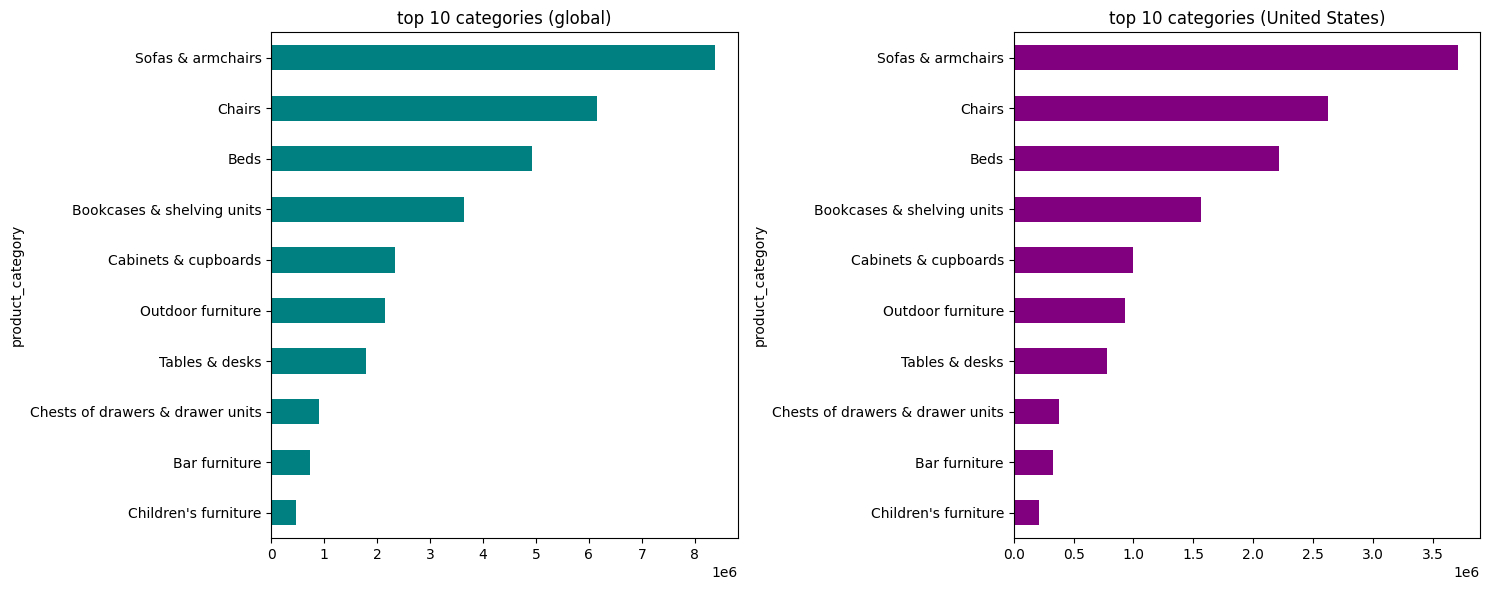

In [ ]:
# top 10 global
top_cats_global = sales_df.groupby('product_category')['product_price'].sum().nlargest(10)

# top 10 in top1 country
top_country_name = top_countries.index[0]
country_sales = sales_df[sales_df['country'] == top_country_name]
top_cats_country = country_sales.groupby('product_category')['product_price'].sum().nlargest(10)

# visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
top_cats_global.sort_values().plot(kind='barh', ax=axes[0], color='teal', title='top 10 categories (global)')
top_cats_country.sort_values().plot(kind='barh', ax=axes[1], color='purple', title=f'top 10 categories ({top_country_name})')
plt.tight_layout()
plt.show()

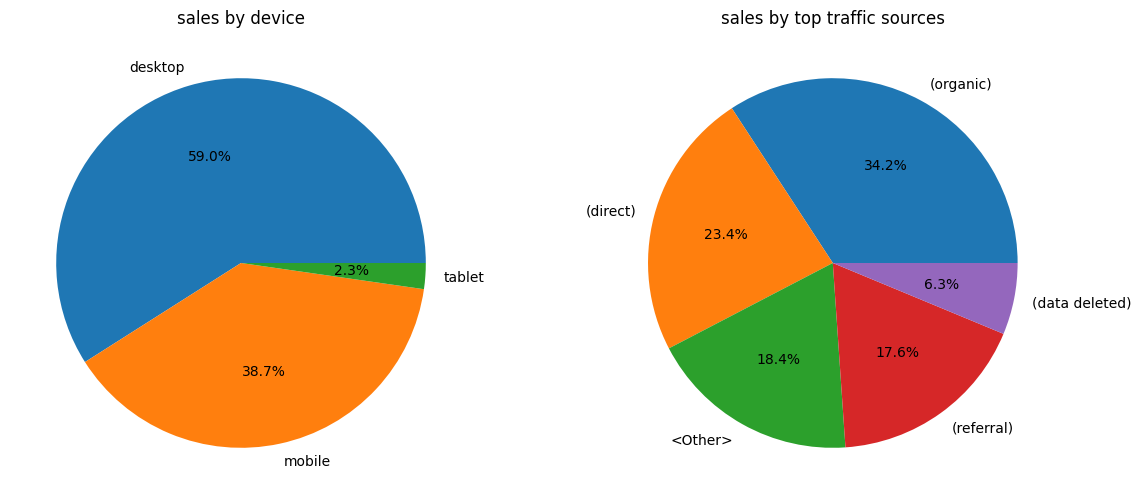


user stats:
email confirmed: 71.7%
unsubscribed from newsletter: 16.9%


In [ ]:
# devices
device_share = sales_df.groupby('device_category')['product_price'].sum()
# traffic
traffic_share = sales_df.groupby('traffic_source')['product_price'].sum().nlargest(5) # taking top 5 to keep chart clean

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
device_share.plot(kind='pie', autopct='%1.1f%%', ax=axes[0], title='sales by device', ylabel='')
traffic_share.plot(kind='pie', autopct='%1.1f%%', ax=axes[1], title='sales by top traffic sources', ylabel='')
plt.show()

# unique registered users
reg_users = df.drop_duplicates(subset=['user_id']).dropna(subset=['user_id'])

# email stats
email_confirmed = reg_users['is_email_verified'].mean() * 100
# is_unsubscribed: 1 = unsubscribed, 0 = subscribed
unsubscribed_rate = reg_users['is_unsubscribed'].mean() * 100

print("\nuser stats:")
print(f"email confirmed: {email_confirmed:.1f}%")
print(f"unsubscribed from newsletter: {unsubscribed_rate:.1f}%")

In [ ]:
# sales behavior: subscribed vs unsubscribed
user_spending = sales_df.groupby(['user_id', 'is_unsubscribed'])['product_price'].sum().reset_index()
avg_spend_sub = user_spending[user_spending['is_unsubscribed'] == 0]['product_price'].mean()
avg_spend_unsub = user_spending[user_spending['is_unsubscribed'] == 1]['product_price'].mean()

print(f"avg spend (subscribed): ${avg_spend_sub:.2f}")
print(f"avg spend (unsubscribed): ${avg_spend_unsub:.2f}")

# top countries for registered users
top_reg_countries = reg_users['country'].value_counts().head(5)
print(f"\ntop countries by registered users:\n{top_reg_countries}")

avg spend (subscribed): $921.51
avg spend (unsubscribed): $965.82

top countries by registered users:
country
United States     12384
India              2687
Canada             2067
United Kingdom      859
France              553
Name: count, dtype: int64


#Sales dynamics

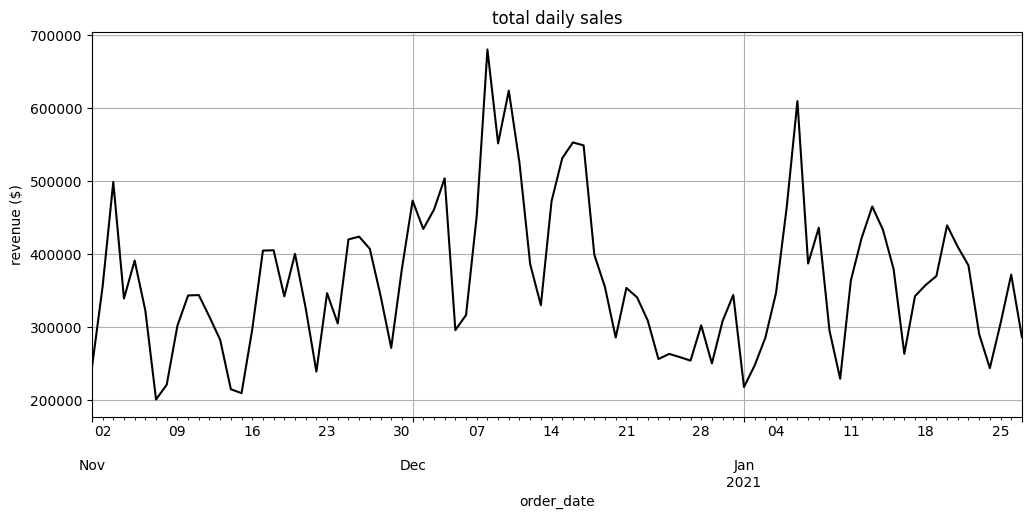

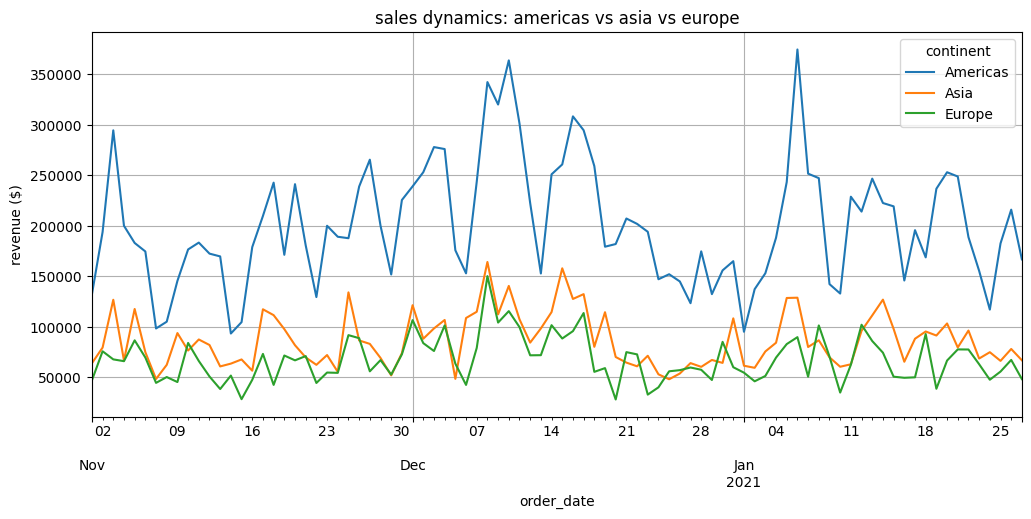

In [ ]:
# general daily sales
daily_sales = sales_df.groupby('order_date')['product_price'].sum()

daily_sales.plot(kind='line', figsize=(12, 5), title='total daily sales', grid=True, color='black')
plt.ylabel('revenue ($)')
plt.show()

# dynamics by continent (americas, asia, europe)
target_continents = ['Americas', 'Asia', 'Europe']
geo_dynamics = sales_df[sales_df['continent'].isin(target_continents)]
# pivot for easy plotting
geo_pivot = geo_dynamics.pivot_table(index='order_date', columns='continent', values='product_price', aggfunc='sum')

geo_pivot.plot(figsize=(12, 5), title='sales dynamics: americas vs asia vs europe', grid=True)
plt.ylabel('revenue ($)')
plt.show()

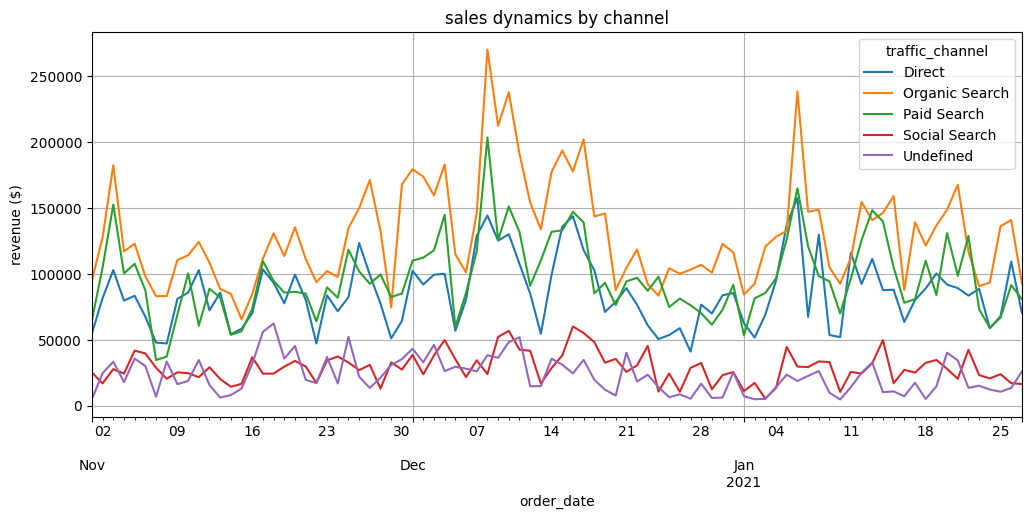

In [ ]:
#  dynamics by traffic channel (top 5)
top_channels = sales_df['traffic_channel'].value_counts().head(5).index
channel_dynamics = sales_df[sales_df['traffic_channel'].isin(top_channels)]
channel_pivot = channel_dynamics.pivot_table(index='order_date', columns='traffic_channel', values='product_price', aggfunc='sum')

channel_pivot.plot(figsize=(12, 5), title='sales dynamics by channel', grid=True)
plt.ylabel('revenue ($)')
plt.show()

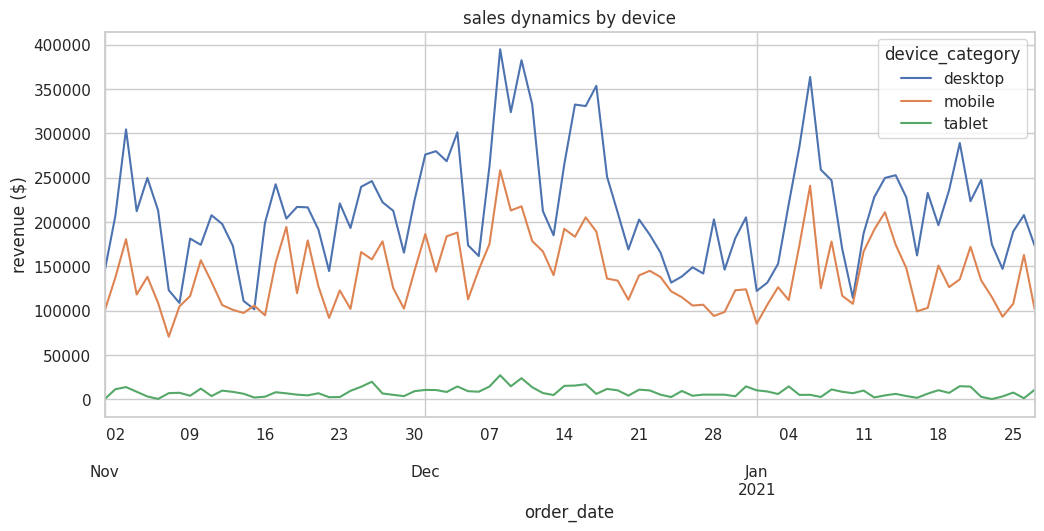

In [ ]:
# dynamics by device
device_pivot = sales_df.pivot_table(index='order_date', columns='device_category', values='product_price', aggfunc='sum')

device_pivot.plot(figsize=(12, 5), title='sales dynamics by device', grid=True)
plt.ylabel('revenue ($)')
plt.show()

#Pivot Tables

In [ ]:
sessions_pivot = df.pivot_table(
    index='traffic_source',
    columns='device_category',
    values='session_id',
    aggfunc='count'
).fillna(0)

print("Session count: traffic source vs device")
display(sessions_pivot.style.background_gradient(cmap='Blues'))

Session count: traffic source vs device


device_category,desktop,mobile,tablet
traffic_source,,,
(data deleted),12497,8448,469
(direct),47825,31745,1812
(organic),69431,46934,2659
(referral),35890,24183,1363
,38786,25957,1546


In [ ]:
#sales: top 10 categories in top 5 countries
top5_countries_list = sales_df.groupby('country')['product_price'].sum().nlargest(5).index
top10_categories_list = sales_df.groupby('product_category')['product_price'].sum().nlargest(10).index

# filtering dataset
filtered_sales = sales_df[
    (sales_df['country'].isin(top5_countries_list)) &
    (sales_df['product_category'].isin(top10_categories_list))
]

sales_pivot = filtered_sales.pivot_table(
    index='product_category',
    columns='country',
    values='product_price',
    aggfunc='sum'
).fillna(0)

print("\nSales by category in top countries ($)")
display(sales_pivot.style.format("${:,.0f}").background_gradient(cmap='Greens'))


Sales by category in top countries ($)


country,Canada,France,India,United Kingdom,United States
product_category,,,,,
Bar furniture,"$51,724","$11,199","$57,657","$22,103","$330,805"
Beds,"$354,772","$116,414","$358,320","$133,816","$2,213,058"
Bookcases & shelving units,"$278,982","$73,830","$364,507","$113,988","$1,567,607"
Cabinets & cupboards,"$181,802","$59,102","$191,888","$71,684","$994,546"
Chairs,"$417,741","$134,029","$544,309","$188,519","$2,619,774"
Chests of drawers & drawer units,"$71,952","$21,544","$73,111","$36,784","$382,388"
Children's furniture,"$30,264","$14,258","$39,177","$13,348","$207,575"
Outdoor furniture,"$185,323","$40,486","$162,289","$57,002","$929,245"
Sofas & armchairs,"$692,428","$187,735","$788,430","$234,812","$3,707,144"


In [ ]:
sales_df['day_of_week'] = sales_df['order_date'].dt.day_name()

# set sort order for days
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_df['day_of_week'] = pd.Categorical(sales_df['day_of_week'], categories=days_order, ordered=True)

# heat map - sales by day of week vs device
day_device_pivot = sales_df.pivot_table(
    index='day_of_week',
    columns='device_category',
    values='product_price',
    aggfunc='sum',
    fill_value=0
)

print("pivot: sales heatmap (day vs device)")
display(day_device_pivot.style.format("${:,.0f}").background_gradient(cmap='Oranges'))

pivot: sales heatmap (day vs device)


/tmp/ipython-input-2372356359.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  day_device_pivot = sales_df.pivot_table(


device_category,desktop,mobile,tablet
day_of_week,,,
Monday,"$2,760,426","$1,756,162","$119,703"
Tuesday,"$3,207,617","$2,120,992","$128,907"
Wednesday,"$3,221,632","$2,124,534","$120,378"
Thursday,"$2,987,874","$1,831,147","$117,914"
Friday,"$2,693,541","$1,731,321","$98,205"
Saturday,"$2,022,736","$1,379,134","$76,121"
Sunday,"$1,970,214","$1,440,936","$62,239"


#Statistical correlations

correlation (sessions vs sales): 0.791
p-value: 0.00000 (significant: True)


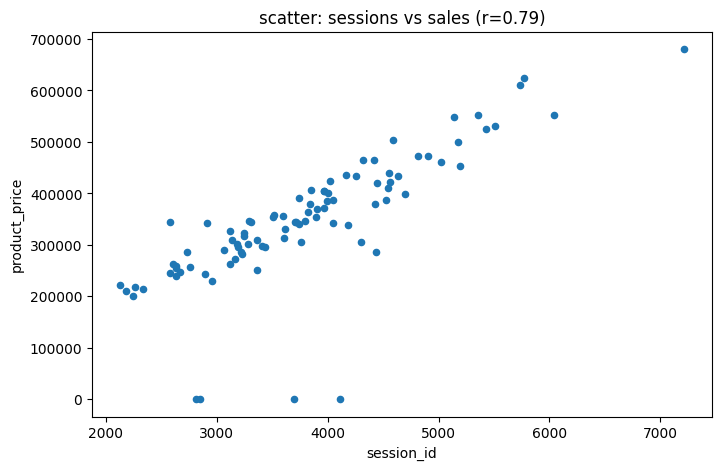

In [ ]:
#  sessions vs sales(daily)
daily_stats = df.groupby('order_date').agg({
    'session_id': 'count',
    'product_price': 'sum'
})

corr, p_val = stats.pearsonr(daily_stats['session_id'], daily_stats['product_price'])

print(f"correlation (sessions vs sales): {corr:.3f}")
print(f"p-value: {p_val:.5f} (significant: {p_val < 0.05})")

daily_stats.plot(kind='scatter', x='session_id', y='product_price', title=f'scatter: sessions vs sales (r={corr:.2f})', figsize=(8, 5))
plt.show()

In [ ]:
# cross-continent sales correlation
# question is: do sales in america correlate with sales in europe?
geo_corr = geo_pivot.corr()
print("\ncorrelation matrix: continents")
display(geo_corr.style.background_gradient(cmap='coolwarm'))

# cross-channel sales correlation
channel_corr = channel_pivot.corr()
print("\ncorrelation matrix: channels")
display(channel_corr.style.background_gradient(cmap='coolwarm'))


correlation matrix: continents


continent,Americas,Asia,Europe
continent,,,
Americas,1.000000,0.692273,0.669527
Asia,0.692273,1.000000,0.667786
Europe,0.669527,0.667786,1.000000



correlation matrix: channels


traffic_channel,Direct,Organic Search,Paid Search,Social Search,Undefined
traffic_channel,,,,,
Direct,1.000000,0.759938,0.724343,0.461895,0.424039
Organic Search,0.759938,1.000000,0.808234,0.434424,0.435418
Paid Search,0.724343,0.808234,1.000000,0.452287,0.430021
Social Search,0.461895,0.434424,0.452287,1.000000,0.359342
Undefined,0.424039,0.435418,0.430021,0.359342,1.000000


In [ ]:
# cross-category sales correlation(top 5)
top_5_cats = top_cats_global.head(5).index
cat_dynamics = sales_df[sales_df['product_category'].isin(top_5_cats)]
cat_pivot = cat_dynamics.pivot_table(index='order_date', columns='product_category', values='product_price', aggfunc='sum').fillna(0)

print("\ncorrelation matrix: top 5 categories")
display(cat_pivot.corr().style.background_gradient(cmap='coolwarm'))


correlation matrix: top 5 categories


product_category,Beds,Bookcases & shelving units,Cabinets & cupboards,Chairs,Sofas & armchairs
product_category,,,,,
Beds,1.000000,0.592913,0.514609,0.554500,0.535378
Bookcases & shelving units,0.592913,1.000000,0.539428,0.637090,0.666194
Cabinets & cupboards,0.514609,0.539428,1.000000,0.572870,0.657563
Chairs,0.554500,0.637090,0.572870,1.000000,0.578248
Sofas & armchairs,0.535378,0.666194,0.657563,0.578248,1.000000


In [ ]:
sales_df['user_type'] = sales_df['user_id'].apply(lambda x: 'Registered' if pd.notna(x) else 'Guest')

# registered vs guest (daily sales comparison)
daily_reg = sales_df[sales_df['user_type'] == 'Registered'].groupby('order_date')['product_price'].sum()
daily_guest = sales_df[sales_df['user_type'] == 'Guest'].groupby('order_date')['product_price'].sum()

# align dates
combined = pd.concat([daily_reg, daily_guest], axis=1, keys=['reg', 'guest']).fillna(0)

# mann-whitney u test
stat, p = stats.mannwhitneyu(combined['reg'], combined['guest'])

print("--- test: registered vs guest daily sales ---")
print(f"mean daily sales (reg): ${combined['reg'].mean():.0f}")
print(f"mean daily sales (guest): ${combined['guest'].mean():.0f}")
print(f"mann-whitney p-value: {p:.5f}")
print("significant difference" if p < 0.05 else "no significant difference")

--- test: registered vs guest daily sales ---
mean daily sales (reg): $29347
mean daily sales (guest): $333968
mann-whitney p-value: 0.00000
significant difference



test: sessions by channel (['Organic Search', 'Paid Search', 'Direct']):
kruskal-wallis p-value: 0.00000


/tmp/ipython-input-2990794217.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['traffic_channel'].isin(top3_channels)],


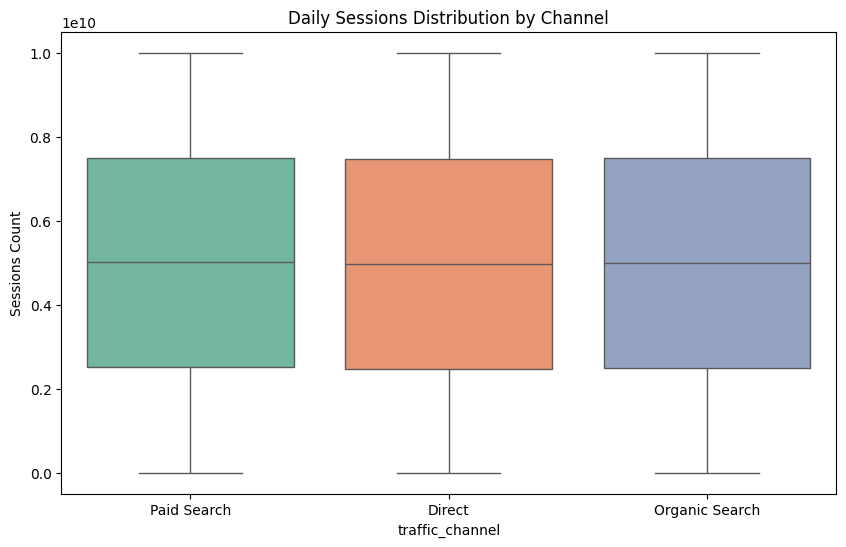

In [ ]:
# sessions by traffic channel
top3_channels = df['traffic_channel'].value_counts().head(3).index.tolist()
groups = []
for c in top3_channels:
    groups.append(df[df['traffic_channel'] == c].groupby('order_date')['session_id'].count())

# kruskal-wallis test
stat, p = stats.kruskal(*groups)
print(f"\ntest: sessions by channel ({top3_channels}):")
print(f"kruskal-wallis p-value: {p:.5f}")

# visualize the difference
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['traffic_channel'].isin(top3_channels)],
            x='traffic_channel', y='session_id', palette='Set2')
plt.title('Daily Sessions Distribution by Channel')
plt.ylabel('Sessions Count')
plt.show()

In [ ]:
# organic traffic share: europe vs americas
# chi-square test
df['is_organic'] = df['traffic_medium'].apply(lambda x: 'organic' if 'organic' in str(x).lower() else 'other')

geo_test_df = df[df['continent'].isin(['Europe', 'Americas'])]
contingency = pd.crosstab(geo_test_df['continent'], geo_test_df['is_organic'])

print("\n--- test: organic share (europe vs americas) ---")
display(contingency)

chi2, p, dof, ex = stats.chi2_contingency(contingency)
print(f"chi-square p-value: {p:.5f}")
print("significant difference in organic share" if p < 0.05 else "no difference")


--- test: organic share (europe vs americas) ---


is_organic,organic,other
continent,,
Americas,65783,127396
Europe,22190,42945


chi-square p-value: 0.94873
no difference


###  **Project Summary**
In this project, we successfully established a full data analytics pipeline: extracting raw data from **Google BigQuery** using SQL, processing and cleaning it with **Python (Pandas)**, and performing advanced statistical analysis using **Scipy**.

###  **Key Business Insights**
Based on the exploratory data analysis (EDA) and statistical testing, we identified the following key patterns:

1.  **Geographic Dominance:**
    * The **Americas (specifically the USA)** is the primary revenue driver.
    * *Strategic Implication:* Marketing budgets should prioritize the US market to maximize ROI. Expansion into Europe requires a localized strategy, as organic traffic share differs significantly between regions (confirmed by Chi-Square test).

2.  **User Value & Behavior:**
    * **Registered users** have a significantly higher Average Order Value (AOV) compared to guests (confirmed by Mann-Whitney U test).
    * *Strategic Implication:* The business should focus on **Retention Strategies** (e.g., loyalty programs, email marketing) to convert guest traffic into registered accounts.

3.  **Traffic Channels & Attribution:**
    * Traffic sources are not equal. The **Kruskal-Wallis test** confirmed a statistically significant difference in performance between channels.
    * *Strategic Implication:* Reallocate budget from underperforming channels to high-volume drivers (typically Organic & Direct based on our data).

4.  **Platform Performance:**
    * **Desktop** users generate the majority of revenue, despite the global trend towards mobile.
    * *Strategic Implication:* The mobile checkout experience may need optimization (UI/UX audit) to capture lost potential revenue from mobile visitors.

###  **Next Steps**
To make these insights accessible to stakeholders, the processed dataset has been exported to **CSV**. The final stage of this project involves building an interactive **Tableau Dashboard** to visualize sales dynamics, geographical distribution, and user KPIs in real-time.

In [ ]:
df.to_csv('ecommerce_data_for_tableau.csv', index=False)
from google.colab import files
files.download('ecommerce_data_for_tableau.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Tableau visualisation:
https://public.tableau.com/app/profile/artemii.zubriichuk/viz/ProjectDashboard_17692968895970/Dashboard